In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
#w=np.array([-.1,-.1,-.1,-.1,-.1, 0])
#w=np.array([-1,-1,-1,-1,-1, 0])
#c=np.array([  1,  1,  1,.01,100, 1e10])*1e-6
e1e2t=214298.32535430687
e3t=np.array([25.70331479, 26.28684983, 26.59728865, 26.75965336, 
              26.84381704, 26.88724213, 26.90959407, 26.92108493,
              26.9269885,  26.93002054, 26.93157752, 26.93237697,])
c=np.array([0.31565186, 0.30992895, 0.3301549,  0.423929,
            0.54217166, 0.54365426, 0.41666764, 0.5127122,
            0.5862078 , 0.02054412, 7.757981,   0.])
w=-1*np.ones(np.shape(c))*2.8e-4
w[-1]=0
tmask=np.ones(np.shape(c))
tmask[-1]=0

In [3]:
#1. bottom value zero
zwz=np.zeros(np.shape(c))
#2. upstream advection
zwz[1:]=w[1:]*c[:-1]
zwz

array([ 0.00000000e+00, -8.83825208e-05, -8.67801060e-05, -9.24433720e-05,
       -1.18700120e-04, -1.51808065e-04, -1.52223193e-04, -1.16666939e-04,
       -1.43559416e-04, -1.64138184e-04, -5.75235360e-06,  0.00000000e+00])

In [4]:
dt=40*2


In [5]:
ztra=np.zeros(np.shape(c))
ztra[:-1]=-1*(zwz[:-1]-zwz[1:])/e1e2t
delc_upwind=ztra.copy() # ** added to tra at this step
zwi=(e3t*c+dt*ztra)/e3t*tmask # set fse3t's to 1
zwi # upwind increases low point from .01 to .0298 in one time step

array([0.31565186, 0.30992895, 0.3301549 , 0.423929  , 0.54217166,
       0.54365426, 0.41666764, 0.5127122 , 0.5862078 , 0.02054412,
       7.757981  , 0.        ])

In [6]:
# 3. antidiffusive flux
zwz_sav=zwz.copy()

In [7]:
jnzts=20 # same as SSC

In [8]:
cb=c.copy()

In [9]:
ca=np.zeros(np.shape(c))
zwzts=np.zeros(np.shape(c))

In [10]:
for jl in range(0,jnzts):
    if jl==0:
        jtaken=np.mod(jnzts+1,2)
        print(jtaken)
        zts=dt/jnzts # z_rzts=1/jnzts
        cn=c.copy() # this makes first step euler
    elif jl==1:
        zts=2*dt/jnzts
    zwz[1:]=.5*w[1:]*(cn[1:]+cn[:-1])
    if jtaken==0:
        zwzts[1:]=zwzts[1:]+zwz[1:]*zts
    jtaken=np.mod(jtaken+1,2) # switch on/off
    
    zbtr=1/(e1e2t*e3t)
    ztra[1:-1]=-1*zbtr[1:-1]*(zwz[1:-1]-zwz[2:])
    ca[1:-1]=cb[1:-1]+zts*ztra[1:-1] # step forward
    # swap for next step:
    cb=cn.copy()
    cn=ca.copy()
    ca=np.zeros(np.shape(c))

1


In [11]:
cn

array([0.        , 0.30992895, 0.3301549 , 0.423929  , 0.54217166,
       0.54365426, 0.41666764, 0.5127122 , 0.5862078 , 0.02054411,
       7.75798102, 0.        ])

In [12]:
zwzts

array([ 0.        , -0.0034712 , -0.00716894, -0.00844574, -0.01082033,
       -0.01216125, -0.01075561, -0.01040905, -0.0123079 , -0.00679562,
       -0.08711948,  0.        ])

In [13]:
# anti-diffusive vertical flux using average flux from sub-timestepping
zwz=zwzts/dt-zwz_sav

In [14]:
zwz

array([ 0.00000000e+00,  4.49924678e-05, -2.83163294e-06, -1.31283740e-05,
       -1.65539724e-05, -2.07564001e-07,  1.77781268e-05, -1.34462384e-05,
       -1.02893840e-05,  7.91929161e-05, -1.08324116e-03,  0.00000000e+00])

In [15]:
zbig=1e40
zrtrn=1e-15

In [16]:
# 4. nonosc(pbef=ptb,zwx,zwy,pcc=zwz,paft=zwi,p2dt)
# zwi is after value based on upwind
pbef=c.copy()
paft=zwi.copy()
# search local extrema
zbup=np.maximum(pbef*tmask-zbig*(1-tmask),paft*tmask-zbig*(1-tmask))
zbup

array([ 3.15651860e-01,  3.09928950e-01,  3.30154900e-01,  4.23929000e-01,
        5.42171660e-01,  5.43654260e-01,  4.16667640e-01,  5.12712200e-01,
        5.86207800e-01,  2.05441222e-02,  7.75798100e+00, -1.00000000e+40])

In [17]:
zbdo=np.minimum(pbef*tmask+zbig*(1-tmask),paft*tmask+zbig*(1-tmask))
zbdo

array([3.15651859e-01, 3.09928950e-01, 3.30154900e-01, 4.23929000e-01,
       5.42171660e-01, 5.43654260e-01, 4.16667640e-01, 5.12712200e-01,
       5.86207800e-01, 2.05441200e-02, 7.75798100e+00, 1.00000000e+40])

In [18]:
zup=np.zeros(np.shape(c))
zdo=zup.copy()
zup[0]=np.maximum(zbup[0],zbup[1])
zup[1:-1]=np.maximum(np.maximum(zbup[:-2],zbup[1:-1]),zbup[2:])
#zup[-1]=np.maximum(zbup[-2],zbup[-1]) this is never calculated
zup

array([0.31565186, 0.3301549 , 0.423929  , 0.54217166, 0.54365426,
       0.54365426, 0.54365426, 0.5862078 , 0.5862078 , 7.757981  ,
       7.757981  , 0.        ])

In [19]:
zdo[0]=np.minimum(zbdo[0],zbdo[1])
zdo[1:-1]=np.minimum(np.minimum(zbdo[:-2],zbdo[1:-1]),zbdo[2:])
#zdo[-1]=np.minimum(zbdo[-2],zbdo[-1])
zdo

array([0.30992895, 0.30992895, 0.30992895, 0.3301549 , 0.423929  ,
       0.41666764, 0.41666764, 0.41666764, 0.02054412, 0.02054412,
       0.02054412, 0.        ])

(12, 0)

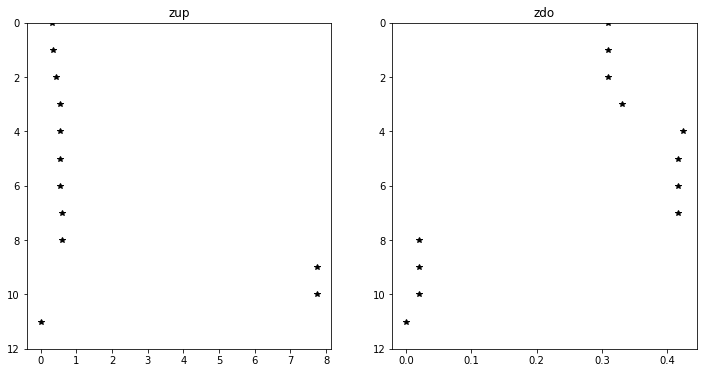

In [20]:
fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].plot(zup,np.arange(0,len(zbup)),'k*')
ax[0].set_title('zup')
ax[0].set_ylim(12,0)
ax[1].plot(zdo,np.arange(0,len(zdo)),'k*')
ax[1].set_title('zdo')
ax[1].set_ylim(12,0)

In [21]:
zeros=np.zeros(np.shape(c))
pcc=zwz.copy()
zpos=np.zeros(np.shape(c))
zneg=zpos.copy()
zpos[:-1]=np.maximum(zeros[1:],pcc[1:])-np.minimum(zeros[:-1],pcc[:-1])
zneg[:-1]=np.maximum(zeros[:-1],pcc[:-1])-np.minimum(zeros[1:],pcc[1:])


In [22]:
zpos

array([4.49924678e-05, 0.00000000e+00, 2.83163294e-06, 1.31283740e-05,
       1.65539724e-05, 1.79856908e-05, 0.00000000e+00, 1.34462384e-05,
       8.94823002e-05, 0.00000000e+00, 1.08324116e-03, 0.00000000e+00])

In [23]:
zneg

array([0.00000000e+00, 4.78241008e-05, 1.31283740e-05, 1.65539724e-05,
       2.07564001e-07, 0.00000000e+00, 3.12243652e-05, 1.02893840e-05,
       0.00000000e+00, 1.16243408e-03, 0.00000000e+00, 0.00000000e+00])

(12, 0)

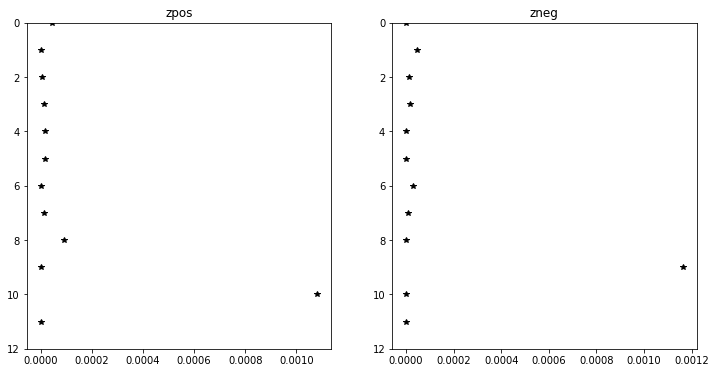

In [24]:
fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].plot(zpos,np.arange(0,len(zpos)),'k*')
ax[0].set_title('zpos')
ax[0].set_ylim(12,0)
ax[1].plot(zneg,np.arange(0,len(zneg)),'k*')
ax[1].set_title('zneg')
ax[1].set_ylim(12,0)

In [25]:
#! up & down beta terms
zbt = e1e2t*e3t / dt
zbetup = ( zup - paft) / ( zpos + zrtrn ) * zbt
zbetdo = ( paft - zdo ) / ( zneg + zrtrn ) * zbt


In [26]:
zbetup

array([1.96438480e+00, 1.42421732e+18, 2.35945721e+09, 6.45613387e+08,
       6.44013491e+06, 2.30808083e-02, 9.15364149e+18, 3.94168472e+08,
       2.29975849e-01, 5.58164992e+20, 0.00000000e+00, 0.00000000e+00])

In [27]:
zbetdo

array([3.94034950e+17, 3.35063722e-02, 1.09765067e+08, 4.06059758e+08,
       4.09633264e+10, 9.14603823e+18, 1.13873419e+00, 6.73138981e+08,
       4.08013816e+19, 1.36253602e-01, 5.58197263e+20, 0.00000000e+00])

(12, 0)

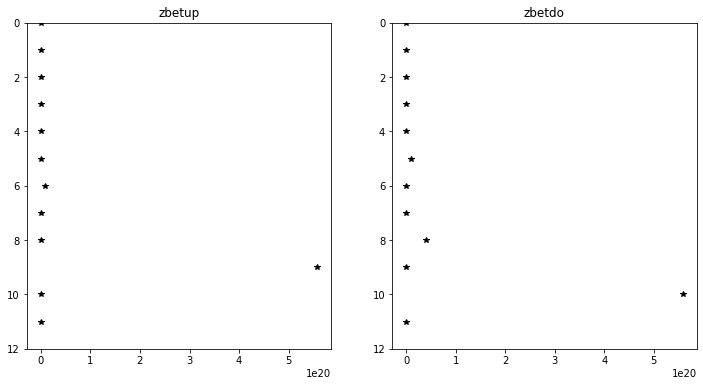

In [28]:
fig,ax=plt.subplots(1,2,figsize=(12,6))
ax[0].plot(zbetup,np.arange(0,len(zbetup)),'k*')
ax[0].set_title('zbetup')
ax[0].set_ylim(12,0)
ax[1].plot(zbetdo,np.arange(0,len(zbetdo)),'k*')
ax[1].set_title('zbetdo')
ax[1].set_ylim(12,0)

In [29]:
#! monotonic flux in the k direction, i.e. pcc
ones=np.ones(np.shape(c))
za=zeros.copy()
zb=zeros.copy()
zc=zeros.copy()
za[:-1] = np.minimum(np.minimum( ones[1:], zbetdo[1:]), zbetup[:-1] )
zb[:-1] = np.minimum(np.minimum( ones[1:], zbetup[1:]), zbetdo[:-1] )
zc[:-1]=np.where(pcc[1:]<0,0,1)
#zc[:-1]=.5+np.abs(pcc[1:])/pcc[1:]*.5
#zc =       ( 0.5  + SIGN( 0.5 , pcc(ji,jj,jk+1) ) )
# SIGN(A,B) returns value of A with sign of B
pcc[1:]=pcc[1:]*(zc[:-1]*za[:-1]+(1-zc[:-1])*zb[:-1])
#pcc(ji,jj,jk+1) = pcc(ji,jj,jk+1) * ( zc * za + ( 1._wp - zc) * zb )

In [30]:
pcc

array([ 0.00000000e+00,  1.50753437e-06, -9.48777474e-08, -1.31283740e-05,
       -1.65539724e-05, -4.79074491e-09,  4.10333536e-07, -1.34462384e-05,
       -2.36630983e-06,  1.07903201e-05, -0.00000000e+00,  0.00000000e+00])

In [31]:
# before nonosc, zwz contains difference between centered substepped leapfrog and upwind:
zwz

array([ 0.00000000e+00,  4.49924678e-05, -2.83163294e-06, -1.31283740e-05,
       -1.65539724e-05, -2.07564001e-07,  1.77781268e-05, -1.34462384e-05,
       -1.02893840e-05,  7.91929161e-05, -1.08324116e-03,  0.00000000e+00])

In [32]:
# after nonosc, zwz (pcc) is adjusted so that only one element changes from upwind 

In [33]:
# 5. final trend with corrected fluxes
ztra=0*ztra
ztra2=ztra.copy()
ztra[:-1]=-1*zbtr[:-1]*(pcc[:-1]-pcc[1:])
ztra2[:-1]=-1*zbtr[:-1]*(zwz[:-1]-zwz[1:])

In [34]:
# total change is ztra+delc, ztra is after nonosc adjustment
ztra

array([ 2.73690241e-13, -2.84457180e-13, -2.28667680e-12, -5.97361442e-13,
        2.87682520e-12,  7.20465354e-14, -2.40286779e-12,  1.92055003e-12,
        2.28001706e-12, -1.86972987e-12,  0.00000000e+00,  0.00000000e+00])

In [35]:
ztra2 # this is before nonosc version

array([ 8.16830419e-12, -8.48964424e-12, -1.80652363e-12, -5.97361442e-13,
        2.84157613e-12,  3.12149100e-12, -5.41461639e-12,  5.47196370e-13,
        1.55070996e-11, -2.01424768e-10,  1.87691491e-10,  0.00000000e+00])

In [36]:
delc_upwind

array([-4.12427492e-10,  7.47749567e-12, -2.64270194e-11, -1.22524280e-10,
       -1.54494650e-10, -1.93715000e-12,  1.65919419e-10, -1.25490840e-10,
       -9.60285992e-11,  7.39090379e-10,  2.68427371e-11,  0.00000000e+00])

In [37]:
delc_upwind+ztra

array([-4.12153801e-10,  7.19303849e-12, -2.87136962e-11, -1.23121641e-10,
       -1.51617825e-10, -1.86510346e-12,  1.63516551e-10, -1.23570290e-10,
       -9.37485822e-11,  7.37220649e-10,  2.68427371e-11,  0.00000000e+00])

In [38]:
delc_upwind+ztra2

array([-4.04259188e-10, -1.01214857e-12, -2.82335430e-11, -1.23121641e-10,
       -1.51653074e-10,  1.18434100e-12,  1.60504802e-10, -1.24943643e-10,
       -8.05214996e-11,  5.37665611e-10,  2.14534228e-10,  0.00000000e+00])

In [39]:
c

array([0.31565186, 0.30992895, 0.3301549 , 0.423929  , 0.54217166,
       0.54365426, 0.41666764, 0.5127122 , 0.5862078 , 0.02054412,
       7.757981  , 0.        ])